In [1]:
#
# Load the wingshape and the known cutting pattern
#

# !!! This is to allow import of https://github.com/goatchurchprime/barmesh
import sys
sys.path.append("/home/julian/repositories")   
import barmesh

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [2]:
#
# Derive the polygons from the network of nodes in UV space ( --> XYZ space by function wingshape.seval )
#
from barmesh.basicgeo import I1, Partition1, P2, P3, Along

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes, bclosed=True)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "plcentre":sum(polyloop, start=P2(0,0))*(1.0/len(polyloop)), 
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)
surfacemeshes[0], surfacemeshes[3] = surfacemeshes[3], surfacemeshes[0]


In [3]:
#
# We need to identify and number the polygons (and some of the edges) appropriately 
# So that we can make the differential offsetting of them
#

#surfacemeshes.sort(key=lambda x: -x["plcentre"].v + x["plcentre"].u*0.05)
#print("{%s}" % ",\n\t".join("'s%d':%s" % (i, "(%.3f, %.3f)" % surfacemesh["plcentre"])  for i, surfacemesh in enumerate(surfacemeshes) ))

patchnamelookups = {   
    'US1':(0.851, 0.865),
    'US2':(3.907, 0.864),
    'LEI1':(0.207, 0.106),
    'LEI2':(0.622, 0.106),
    'LEI3':(1.045, 0.106),
    'LEI4':(1.481, 0.106),
    'LEI5':(2.158, 0.106),
    'LEI6':(3.484, 0.106),
    'LEI7':(4.734, 0.106),
    'LEI8':(5.612, 0.106),
    'TSF1':(0.851, -0.294),
    'TSF2':(3.907, -0.294),
    'TSM1':(0.415, -0.913),
    'TSM2':(1.266, -0.913),
    'TSM3':(3.394, -0.827),
    'TSR':(4.082, -1.073) }

for surfacemesh in surfacemeshes:
    surfacemesh["patchname"] = min(((surfacemesh["plcentre"] - P2(*p)).Len(), name)  for name, p in patchnamelookups.items())[1]
assert len(set(surfacemesh["patchname"]  for surfacemesh in surfacemeshes)) == len(patchnamelookups)
surfacemeshesdict = dict((surfacemesh["patchname"], surfacemesh)  for surfacemesh in surfacemeshes)


In [4]:
#
# Forcefully offset the top and bottom (trailing edge) seam trims outward on the surface extension
# by 18mm, so the patch can then be offset by 6m all round to simulate differential offsetting 
# of 6mm at normal seams and 24mm at these foldover seams.
# produces polylinefoldlinepenmarks for use later for drawing some lines
#

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from barmesh import barmesh
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour, WNode
from wingflatten_barmeshfuncs import polyloopvedgeseqpolyline, polylinewithinsurfaceoffset

def splicereplacedpolylineintoloop(polyloop, i0, i1, polyline, legsampleleng):
    assert 0 < i0 < i1 < len(polyloop) - 1, (0, i0, i1, len(polyloop))
    def intermediatesamplelegsteps(p0, p1, legsampleleng):
        Nsteps = int((p1 - p0).Len()/legsampleleng + 0.9)
        return [ Along(i/Nsteps, p0, p1)  for i in range(1, Nsteps) ]
    return polyloop[:i0] + \
           intermediatesamplelegsteps(polyloop[i0-1], polyline[0], legsampleleng) + \
           polyline + \
           intermediatesamplelegsteps(polyline[-1], polyloop[i1+1], legsampleleng) + \
           polyloop[i1+1:]

# double folds are at 12-6 and 24-6 before the offset by 6
offsetstretchcomponents = [ ("US1", -10, wingshape.vrange[1], 0.006, P2(0, 0.002), True), 
                            ("US2", 0, wingshape.vrange[1], 0.006, P2(0, 0.002), True), 
                            ("TSM1", 10, wingshape.vrange[0], 0.012, P2(0, -0.002), False), 
                            ("TSM1", 10, wingshape.vrange[0], 0.018, P2(0, -0.002), True), 
                            ("TSM2", 0, wingshape.vrange[0], 0.012, P2(0, -0.002), False), 
                            ("TSM2", 0, wingshape.vrange[0], 0.018, P2(0, -0.002), True), 
                            ("TSR", 0, wingshape.vrange[0], 0.012, P2(0, -0.002), False), 
                            ("TSR", 0, wingshape.vrange[0], 0.018, P2(0, -0.002), True) 
                          ]
polylinefoldlinepenmarks = { }
for patchname, irot, vedge, rad, spstep, spliceloop in offsetstretchcomponents:
    surfacemesh = surfacemeshesdict[patchname]
    assert "polyloopOrg" not in surfacemesh
    polyloop = surfacemesh["polyloop"]
    polyloop = polyloop[irot:] + polyloop[:irot]
    i0, i1 = polyloopvedgeseqpolyline(polyloop, vedge)
    print(patchname, i0, i1, rad)
    polyline = polyloop[i0:i1+1]
    if patchname not in polylinefoldlinepenmarks:
        polylinefoldlinepenmarks[patchname] = [ polyline ]
    polylineOffset = polylinewithinsurfaceoffset(wingshape, polyline, rad, spstep)
    if spliceloop: 
        polyloop = splicereplacedpolylineintoloop(polyloop, i0, i1, polylineOffset, parapolygraph.legsampleleng)
        surfacemesh["polyloopOrg"] = surfacemesh["polyloop"]
        surfacemesh["polyloop"] = polyloop
        surfacemesh["polyloopW"] = [ wingshape.seval(p)  for p in polyloop ]
        surfacemesh["plurg"] = I1.AbsorbList(p[0]  for p in polyloop), 
        surfacemesh["plvrg"] = I1.AbsorbList(p[1]  for p in polyloop),
    else:
        polylinefoldlinepenmarks[patchname].append(polylineOffset)
    #if spliceloop:  break   # end early for testing


US1 10 578 0.006
make triangle boxing at 0.01
make triangle boxing at 0.01
ii [P2(0.0, 1.377674932021222), P2(0.0, 1.3804601133171719)]
US2 1480 2950 0.006
make triangle boxing at 0.01
make triangle boxing at 0.01
ii [P2(1.7024664438960757, 1.377890792633085), P2(1.7024664438960757, 1.3809002192013609)]
TSM1 887 1164 0.012
make triangle boxing at 0.01
make triangle boxing at 0.01
TSM1 887 1164 0.018
make triangle boxing at 0.01
make triangle boxing at 0.01
ii [P2(0.8303331789469899, -1.3777628115632021), P2(0.8303331789469898, -1.3806357518251304), P2(0.8303331789469897, -1.3835086920870587), P2(0.8303331789469898, -1.386381632348987), P2(0.8303331789469898, -1.3892545726109156), P2(0.8303331789469898, -1.3921275128728439)]
TSM2 196 487 0.012
make triangle boxing at 0.01
make triangle boxing at 0.01
TSM2 196 487 0.018
make triangle boxing at 0.01
make triangle boxing at 0.01
ii [P2(1.7024664438960762, -1.3777452545614013), P2(1.702466443896076, -1.3806065940804033), P2(1.70246644389607

In [5]:
#
# Calculate the offsets of the polygons based on a common rectangular subdivision spacing xpartA, xpartB
# and product a contour in UV space that would project to the offset 3D surface
#

radoffset = 0.006
uspacing, vspacing = 0.02, 0.02
rd2 = max(uspacing, vspacing, radoffset*2) + 0.01

battonuvlines = [ ]
for u in wingshape.leadingedgelengths[1:-1]:
    battonuvlines.append([P2(u, v)  for v in numpy.arange(wingshape.vrange[0]-vspacing, wingshape.vrange[1]+vspacing, vspacing)])

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour

#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from wingflatten_barmeshfuncs import subloopsequence
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1

urgA, vrgA = I1(*wingshape.urange).Inflate(0.06), I1(*wingshape.vrange).Inflate(0.11)
xpartA = Partition1(urgA.lo, urgA.hi, int(urgA.Leng()/uspacing + 2))
ypartA = Partition1(vrgA.lo, vrgA.hi, int(vrgA.Leng()/vspacing + 2))

def SubPartition(part, vlo, vhi):
    res = Partition1(0, 1, 2)
    ilo, ihi = part.GetPartRange(vlo, vhi)
    res.vs = part.vs[ilo:ihi+2]
    res.lo, res.hi = res.vs[0], res.vs[-1]
    res.nparts = ihi - ilo + 1
    assert len(res.vs) == res.nparts + 1
    assert res.lo < vlo < vhi < res.hi, (res.lo , vlo , vhi , res.hi)
    return res

for i in range(0, len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    print("\nStarting", i, surfacemesh["patchname"])
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = SubPartition(xpartA, urg.lo, urg.hi)
    ypart = SubPartition(ypartA, vrg.lo, vrg.hi)

    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop, boxwidth=0.01)
    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    contourdelta = min(uspacing, vspacing)*0.2
    
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()

    surfacemesh["barmeshoffset"] = bm
    surfacemesh["xpart"] = xpart
    surfacemesh["ypart"] = ypart

    nxs = xpart.nparts + 1
    for iy in range(ypart.nparts + 1):
        for ix in range(nxs):
            assert bm.nodes[iy*nxs + ix].sp == P2(xpart.vs[ix], ypart.vs[iy])
    


Starting 0 US2
make triangle boxing at 0.01
make triangle boxing at 0.01
MakePointZoneRFS done on 13452 nodes
do splitbarsdirectionchangesR on 26617 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  554
nsegs: 569 bad: 0 working: 0
71 [20, 10, 10, 0, 8, 5, 10, 0, 8, 0, 0, 0, 0]

Starting 1 TSF2
make triangle boxing at 0.01
make triangle boxing at 0.01
MakePointZoneRFS done on 5244 nodes
do splitbarsdirectionchangesR on 10237 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  478
nsegs: 495 bad: 0 working: 0
85 [20, 10, 15, 10, 5, 5, 0, 5, 5, 5, 5, 0, 0, 0, 0]

Starting 2 LEI5
make triangle boxing at 0.01
make triangle boxing at 0.01
MakePointZoneRFS done on 1664 nodes
do splitbarsdirectionchangesR on 3244 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  144
nsegs: 164 bad: 0 working: 0
96 [20, 15, 15, 0, 8, 15, 5, 5, 5, 8, 0, 0, 0, 0]

Starting 3 LEI6
make triangle boxing at 0.01
make triangle boxing at 0.01
MakePointZoneRFS done on 3040

In [6]:
#
# Find and triangulate all the cpolys (polygons in the uvcells) per offsetmesh
#

from barmesh import barmesh
from wingflatten_barmeshfuncs import findallnodesandpolys, cpolytriangulate

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    xpart = surfacemesh["xpart"]
    ypart = surfacemesh["ypart"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    surfacemesh["offsettopbar"] = topbars[0]
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]
    tnodes, cpolys = findallnodesandpolys(bm)
    ptsF = [ node.sp  for node in tnodes ]
    surfacemesh["pts"] = numpy.array([ node.p  for node in tnodes ])
    surfacemesh["uvpts"] = uvpts = numpy.array(ptsF)
    tris = [ ]
    for cpoly in cpolys:
        tris.extend(cpolytriangulate(ptsF, cpoly))

    surfacemesh["tris"] = numpy.array(tris)
    surfacemesh["offsetloopI"] = [n.i for n in outercont]
    print(surfacemesh["patchname"], "points", len(ptsF), "triangles", len(tris))


US2 points 12359 triangles 24147
TSF2 points 4131 triangles 7765
LEI5 points 1378 triangles 2590
LEI6 points 2586 triangles 4917
LEI7 points 1180 triangles 2209
TSM3 points 7000 triangles 13558
TSR points 5098 triangles 9496
LEI4 points 733 triangles 1346
LEI8 points 1510 triangles 2849
US1 points 4863 triangles 9432
LEI1 points 697 triangles 1281
LEI2 points 700 triangles 1285
TSF1 points 1611 triangles 3000
LEI3 points 700 triangles 1285
TSM2 points 2333 triangles 4459
TSM1 points 2281 triangles 4360


In [7]:
#
# Call the surface flattener (produces surfacemesh["fpts"], "triareas", "ftriareas")
#

#freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "freecad"   # nixos install

from parapolygraph import trimeshesflattener
trimeshesflattener(surfacemeshes, freecadappimage)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=12359, tris=24147) flattened
mesh (pts=4131, tris=7765) flattened
mesh (pts=1378, tris=2590) flattened
mesh (pts=2586, tris=4917) flattened
mesh (pts=1180, tris=2209) flattened
mesh (pts=7000, tris=13558) flattened
mesh (pts=5098, tris=9496) flattened
mesh (pts=733, tris=1346) flattened
mesh (pts=1510, tris=2849) flattened
mesh (pts=4863, tris=9432) flattened
mesh (pts=697, tris=1281) flattened
mesh (pts=700, tris=1285) flattened
mesh (pts=1611, tris=3000) flattened
mesh (pts=700, tris=1285) flattened
mesh (pts=2333, tris=4459) flattened
mesh (pts=2281, tris=4360) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



In [8]:
#
# Rotate and move the flat pieces produce the exploded diagram
#
from wingflatten_barmeshfuncs import applyconsistenrotationtoflats

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    applyconsistenrotationtoflats(surfacemesh)

<IPython.core.display.Javascript object>


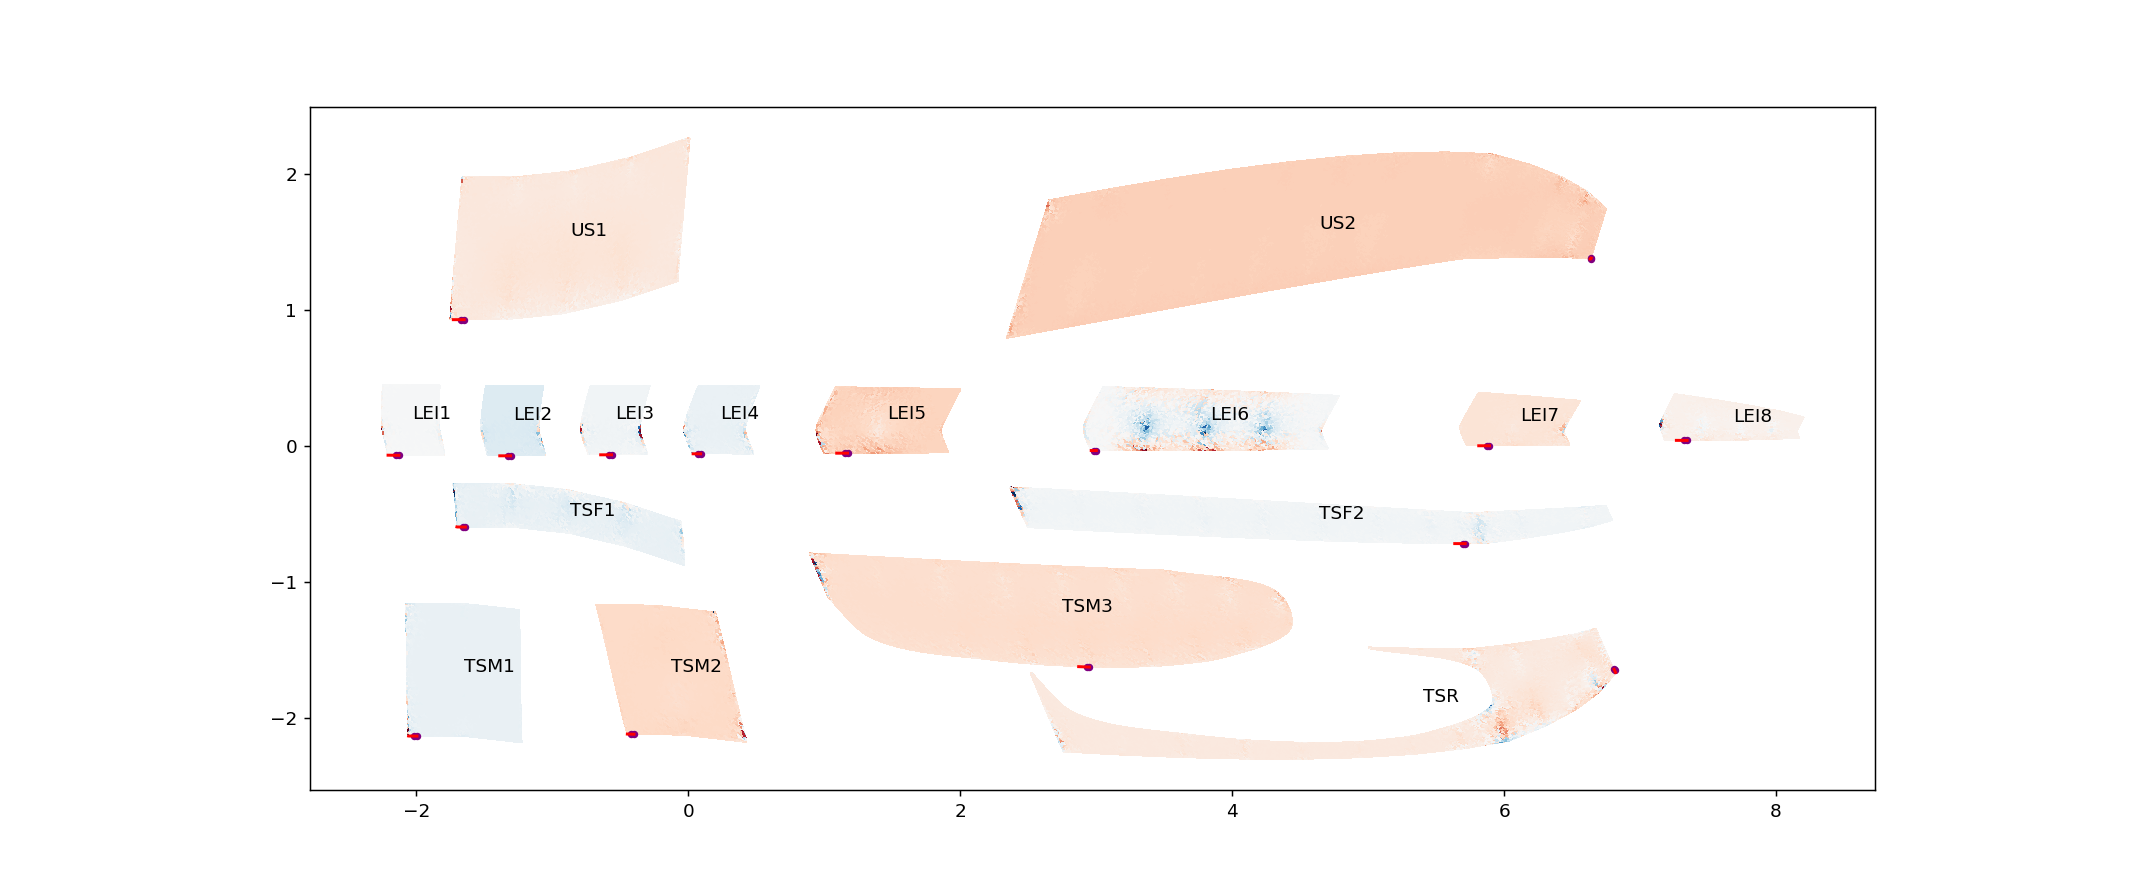

In [9]:
# 
# Exploded diagram of the flattened pieces
# 

%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["fptsT"]
    #fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange, cmap='RdBu')

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[-10:-5,0], contour[-10:-5,1], color="red", linewidth=1.6)
    plt.scatter(contour[-10:-8,0], contour[-10:-8,1], color="purple", marker=".")

plt.gca().autoscale()
plt.gca().set_aspect("equal")
#plt.colorbar()


<IPython.core.display.Javascript object>


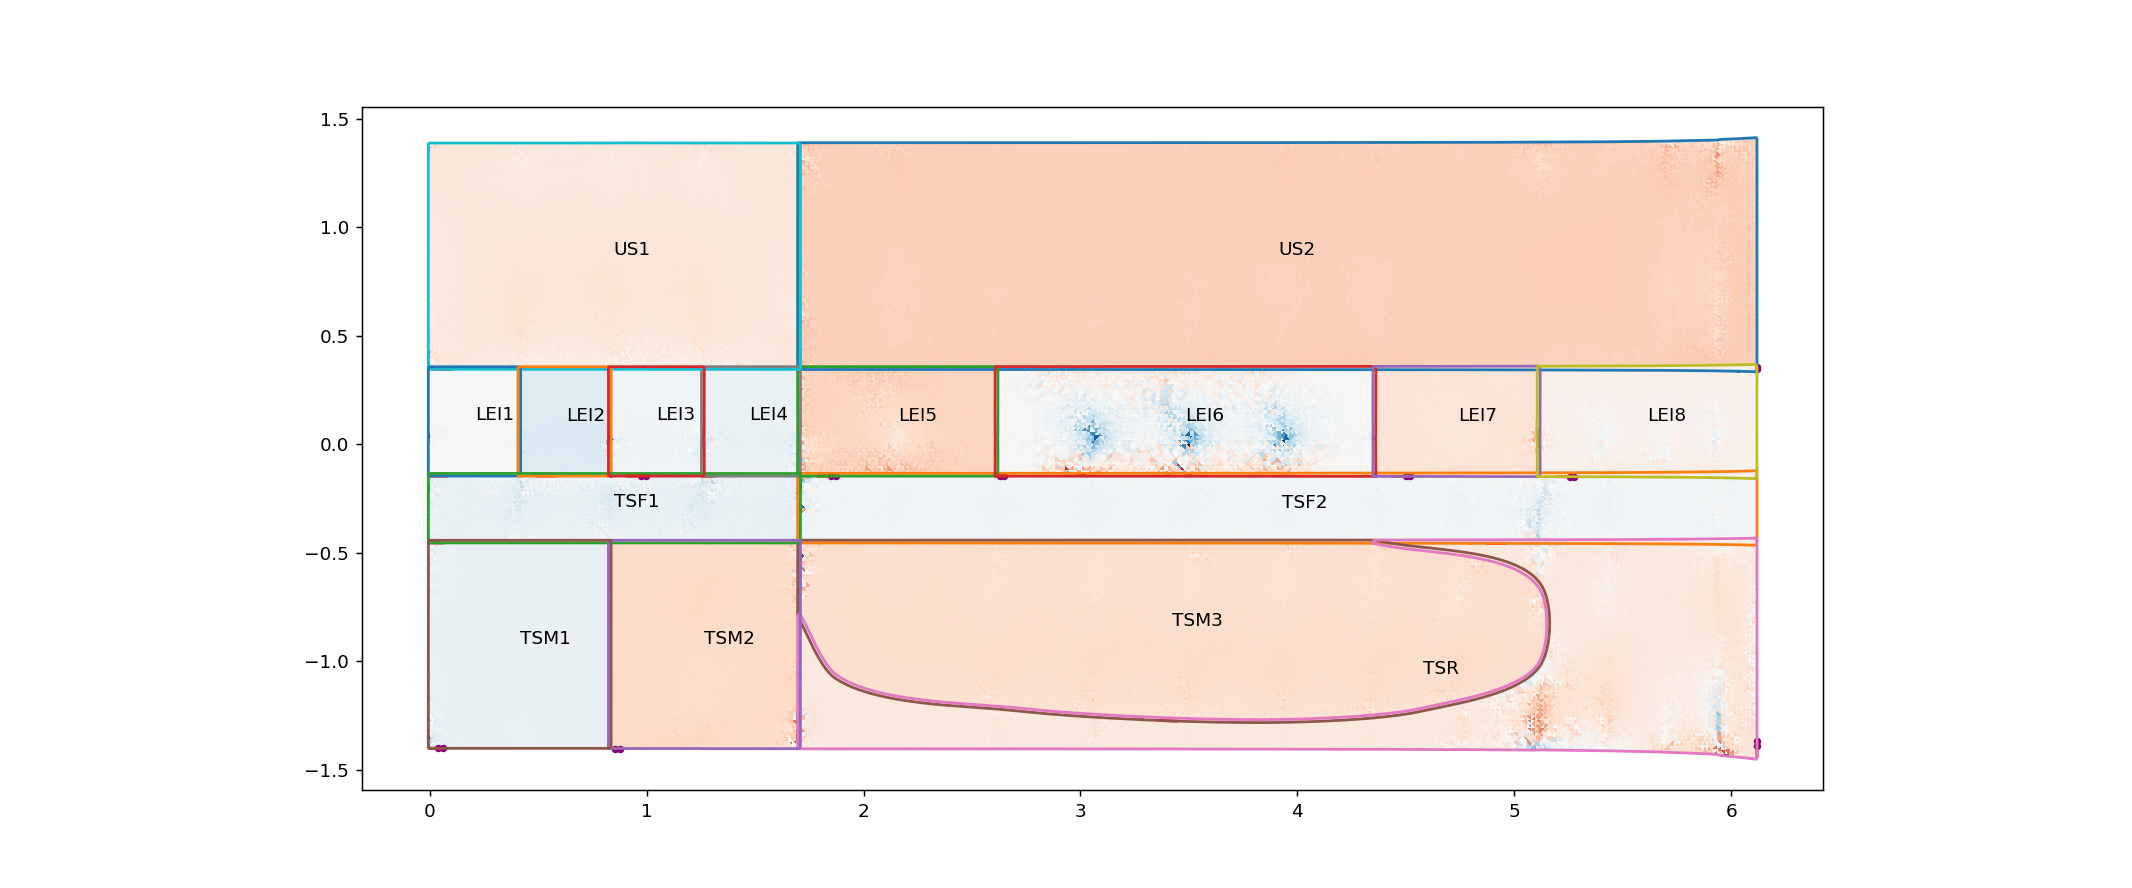

US2 areachange ratios 0.9996166596295776 1.0006234908500249
TSF2 areachange ratios 0.9988765391189589 1.0010532242108157
LEI5 areachange ratios 0.9985086111671918 1.0023393922960429
LEI6 areachange ratios 0.9995373531823772 1.000447887549339
LEI7 areachange ratios 0.9947059147296163 1.0069328746757995
TSM3 areachange ratios 0.9998187843465854 1.0002556553550828
TSR areachange ratios 0.9997046811541307 1.0003622188774
LEI4 areachange ratios 0.9945420508015438 1.0047440896530118
LEI8 areachange ratios 0.9936357349903602 1.0070123137799414
US1 areachange ratios 0.999013623143048 1.0012418435601416
LEI1 areachange ratios 0.980207095880621 1.019448475330572
LEI2 areachange ratios 0.9925562876776846 1.0056308452344935
TSF1 areachange ratios 0.9954863926355347 1.0038702288501387
LEI3 areachange ratios 0.9947101456005286 1.0049133332376412
TSM2 areachange ratios 0.9996970658707243 1.000448707207194
TSM1 areachange ratios 0.9987175972613435 1.001108437721496


In [10]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange, cmap='RdBu')

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[-10:-5,0], contour[-10:-5,1], color="red", linewidth=1.6)
    plt.scatter(contour[-10:-8,0], contour[-10:-8,1], color="purple", marker=".")

    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
    print(surfacemesh["patchname"], "areachange ratios", min(areachange), max(areachange))
    
plt.gca().autoscale()
plt.gca().set_aspect("equal")
#plt.colorbar()


In [11]:
#
# Compute the local transform uvpts->fptsT within each of the cpoly pieces of the mesh
#

from wingflatten_barmeshfuncs import generatecpolytransformfunction

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    generatecpolytransformfunction(surfacemesh)
    print(surfacemesh["patchname"], "x-trianglestrips", sum(len(cpolycolumn)  for cpolycolumn in surfacemesh["cpolycolumns"]))
    

US2 x-trianglestrips 12070
TSF2 x-trianglestrips 3876
LEI5 x-trianglestrips 1289
LEI6 x-trianglestrips 2451
LEI7 x-trianglestrips 1098
TSM3 x-trianglestrips 6778
TSR x-trianglestrips 4742
LEI4 x-trianglestrips 667
LEI8 x-trianglestrips 1419
US1 x-trianglestrips 4712
LEI1 x-trianglestrips 635
LEI2 x-trianglestrips 637
TSF1 x-trianglestrips 1495
LEI3 x-trianglestrips 638
TSM2 x-trianglestrips 2226
TSM1 x-trianglestrips 2174


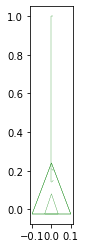

In [12]:
import ezdxf

battendetail = "batten detail TSR.dxf"
docbattendetail = ezdxf.readfile(battendetail)
dxflines = [ k  for k in docbattendetail.entities  if "-CUT" in k.dxf.layer or "PLOT" in k.dxf.layer ]
battendetaillines = [ ]
for line in dxflines:
    p0, p1 = P2(line.dxf.start.x, line.dxf.start.y)*0.001, P2(line.dxf.end.x, line.dxf.end.y)*0.001
    battendetaillines.extend([p0, p1])
dxflinelayers = [ k.dxf.layer  for k in dxflines ]
uvoffsettobettertriangle = P2(0, 0.1)
battonuvdetailpositions = [ (P2(u, wingshape.vrange[0]), P2(u, wingshape.vrange[0])+uvoffsettobettertriangle) \
                               for u in wingshape.leadingedgelengths[1:-1] ]

%matplotlib inline
bdsegs = [ [ battendetaillines[i], battendetaillines[i+1]]  for i in range(0, len(battendetaillines), 2) ]
plt.gca().add_collection(LineCollection(bdsegs, color="green", linewidth=0.3))
plt.gca().autoscale()
plt.gca().set_aspect("equal")


In [13]:
# moved back out from the py file as it needs work

def findcctriangleinmesh(sp, xpart, cpolycolumns):
    if not (xpart.lo < sptriangle[0] < xpart.hi):
        return None
    ix = xpart.GetPart(sp[0])
    if len(cpolycolumns[ix]) == 0:
        return None
    return min((cc  for cc in cpolycolumns[ix]), key=lambda X: (X["cpt"] - sp).Len())

def projectdetaillines(sporigin, sptriangle, xpart, cpolycolumns, uspacing, vspacing, battendetaillines):
    cc = findcctriangleinmesh(sptriangle, xpart, cpolycolumns)
    if cc is None:
        return [ ]
    if abs(cc["cpt"][0] - sptriangle.u) > uspacing or abs(cc["cpt"][1] - sptriangle.v) > vspacing:
        return [ ]
    vc = sporigin - cc["cpt"]
    vcp = cc["urvec"]*vc.u + cc["vrvec"]*vc.v
    vcs = cc["vj"]*vcp.u + cc["vj1"]*vcp.v # should be same as vc
    vcsT = cc["vjT"]*vcp.u + cc["vj1T"]*vcp.v

    # use the 6mm expansion on either side of this line to our advantage
    ccLeft = findcctriangleinmesh(sptriangle-P2(0.005, 0), xpart, cpolycolumns)
    ccRight = findcctriangleinmesh(sptriangle+P2(0.005, 0), xpart, cpolycolumns)
    assert ccLeft != None and ccRight != None, (ccLeft, ccRight)
    
    trailingedgevecL = P2.ZNorm(ccLeft["vjT"]*ccLeft["urvec"].u + ccLeft["vj1T"]*ccLeft["urvec"].v)
    trailingedgevecR = P2.ZNorm(ccRight["vjT"]*ccRight["urvec"].u + ccRight["vj1T"]*ccRight["urvec"].v)
    #trailingedgevec = P2.ZNorm(cc["vjT"]*cc["urvec"].u + cc["vj1T"]*cc["urvec"].v)
    trailingedgevec = P2.ZNorm(trailingedgevecL + trailingedgevecR)
    #print("trailingedge angles ", trailingedgevecL.Arg(), trailingedgevecR.Arg())
    trailingedgevecPerp = P2.ZNorm(cc["vjT"]*cc["vrvec"].u + cc["vj1T"]*cc["vrvec"].v)
    #trailingedgevec = P2.CPerp(trailingedgevecPerp)
    
    battendetails = [ ]
    for lsp in battendetaillines:
        battendetails.append(vcsT + cc["cptT"] + trailingedgevec*lsp.u + trailingedgevecPerp*lsp.v)
    return battendetails



<IPython.core.display.Javascript object>


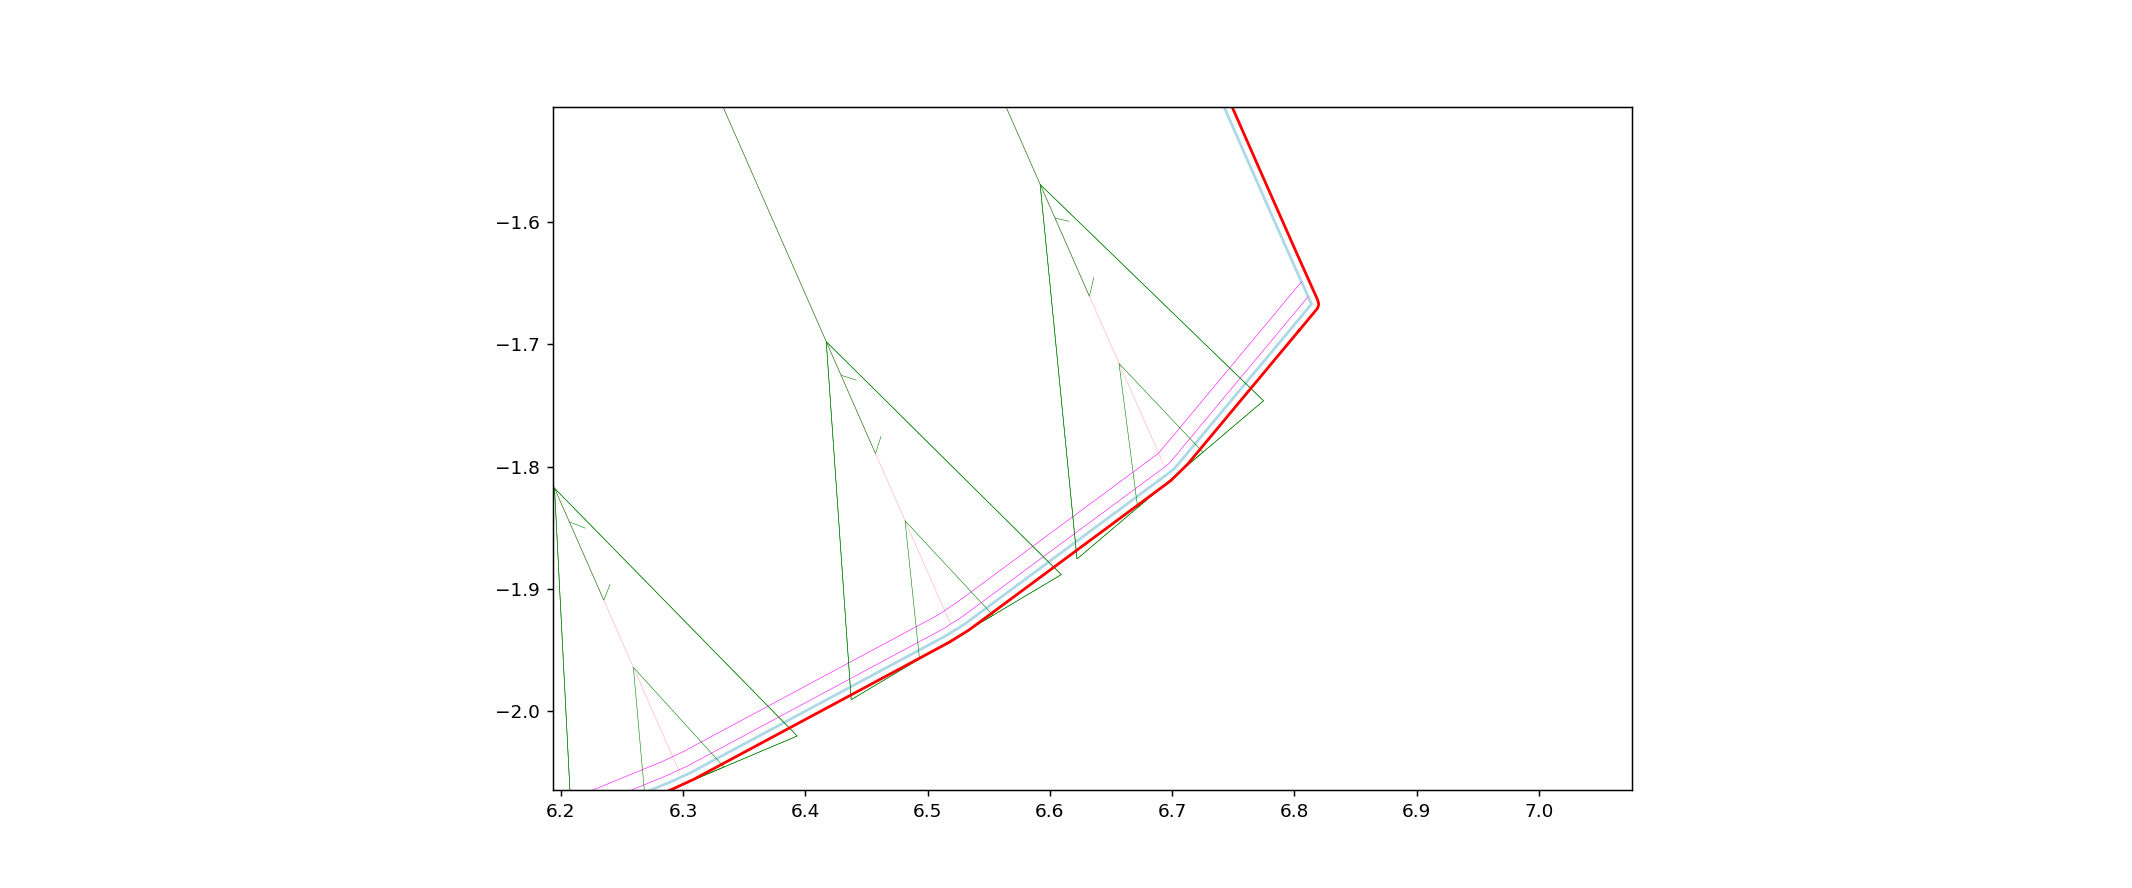

In [14]:
# 
# projecting UV shapes into flattened area where cell is complete
# 

%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection

from wingflatten_barmeshfuncs import sliceupatnones
from wingflatten_barmeshfuncs import projectspbarmeshF
#from wingflatten_barmeshfuncs import projectdetaillines


plt.figure(figsize=(12,5))
bFlattenedPatches = True

for I in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[I]
    bm, xpart, ypart = surfacemesh["barmeshoffset"], surfacemesh["xpart"], surfacemesh["ypart"]

    # uvpts is original parametric space, pts is 3D space, fpts is flattened space, fptsT is rotated and moved flattened piece
    uvpts = surfacemesh["uvpts"]
    fptsT = surfacemesh["fptsT"] if bFlattenedPatches else surfacemesh["uvpts"]

    polyi = surfacemesh["offsetloopI"]
    polyloop = surfacemesh["polyloop"]
    cpolycolumns = surfacemesh["cpolycolumns"]

    if bFlattenedPatches:
        sps = [ fptsT[k]  for k in polyi ]
        plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
        polyloopF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyloop ]
        plt.gca().add_collection(LineCollection(sliceupatnones(polyloopF), color="lightblue"))
        for battonuvline in battonuvlines:
            battonlineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in battonuvline ]
            plt.gca().add_collection(LineCollection(sliceupatnones(battonlineF), color="pink", linewidth=0.4))

            
    else:
        sps = [ uvpts[k]  for k in polyi ]
        plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
        plt.plot([sp[0] for sp in polyloop], [sp[1] for sp in polyloop], color="lightblue")
        if I == 0:
            for battonuvline in battonuvlines:
                plt.plot([sp[0] for sp in battonuvline], [sp[1] for sp in battonuvline], color="pink")
        
    for J in range(len(surfacemeshes)):
        if J == I:
            continue
        surfacemeshJ = surfacemeshes[J]
        polyiJ = surfacemeshJ["offsetloopI"]
        fptsJ = surfacemeshJ["uvpts"]
        spsJ = [ fptsJ[i]  for i in polyiJ ]
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        plt.gca().add_collection(LineCollection(sliceupatnones(spsJF), color="green", linewidth=0.3))

    for spsJ in polylinefoldlinepenmarks.get(surfacemesh["patchname"], [ ]):
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        plt.gca().add_collection(LineCollection(sliceupatnones(spsJF), color="magenta", linewidth=0.3))
        
    battendetailsegments = [ ]
    for sporigin, sptriangle in battonuvdetailpositions:
        battendetailsegments.extend(projectdetaillines(sporigin, sptriangle, xpart, cpolycolumns, uspacing, vspacing, battendetaillines))
    bdsegs = [ [ battendetailsegments[i], battendetailsegments[i+1]]  for i in range(0, len(battendetailsegments), 2) ]
    plt.gca().add_collection(LineCollection(bdsegs, color="green", linewidth=0.3))
    

        
plt.gca().autoscale()
plt.gca().set_aspect("equal")


In [15]:
#
# Measure the projected shared seams between given pairs of patches
#

from wingflatten_barmeshfuncs import subloopsequence

def projectcurvelength(polyline, surfacemesh):
    xpart = surfacemesh["xpart"]
    uvpts = surfacemesh["uvpts"]
    fptsT = surfacemesh["fptsT"]
    cpolycolumns = surfacemesh["cpolycolumns"]
    polylineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyline ]
    return sum((p1-p2).Len()  for p1, p2 in zip(polylineF, polylineF[1:]))

def real3dcurvelength(polyline):
    polylineR = [ parapolygraph.wingshape.seval(p)  for p in polyline ] 
    return sum((p1-p2).Len()  for p1, p2 in zip(polylineR, polylineR[1:]))


def sharededgelengths(poly1, poly2):
    surfacemesh1 = surfacemeshesdict[poly1]
    surfacemesh2 = surfacemeshesdict[poly2]

    polynodesshared = subloopsequence(surfacemesh1["polynodes"], set(surfacemesh2["polynodes"]))
    polylineshared = parapolygraph.splinedpolypoints(polynodesshared[0], bclosed=False)

    reallength = real3dcurvelength(polylineshared)
    poly1projlength = projectcurvelength(polylineshared, surfacemesh1)
    poly2projlength = projectcurvelength(polylineshared, surfacemesh2)

    return (poly1, poly2, reallength, poly1projlength, poly2projlength)


print("patch1\tpatch2\treal\tflat1\tflat2")
patchpairs = [ ("US1", "US2"), ("LEI1", "LEI2"), ("LEI5", "LEI6"), 
               ("TSM1", "TSM2"), ("TSF2", "TSM3"), 
               ("TSM2", "TSR"), ("TSM2", "TSM3") ]
for poly1, poly2 in patchpairs:
    print("%s\t%s\t%.4f\t%.4f\t%.4f" % sharededgelengths(poly1, poly2))
    

patch1	patch2	real	flat1	flat2
US1	US2	1.0456	1.0455	1.0456
LEI1	LEI2	0.5161	0.5155	0.5156
LEI5	LEI6	0.5047	0.5039	0.5036
TSM1	TSM2	0.9512	0.9512	0.9512
TSF2	TSM3	2.6291	2.6291	2.6290
TSM2	TSR	0.6047	0.6047	0.6046
TSM2	TSM3	0.3504	0.3504	0.3504


In [16]:
#
# Now output to the dxf file
#

import ezdxf, os

AAMA_CUT = "1"
AAMA_DRAW = "8"
AAMA_INTCUT = "11"

outputfilename = "test.dxf"
dxfversion = "R12"
breflY = False

def convvectoez(pt, breflY):
    return ezdxf.math.Vec3(pt[0]*1000, -pt[1]*1000 if breflY else pt[1]*1000, 0.0)

blockbasename = os.path.splitext(os.path.split(outputfilename)[1])[0]
doc = ezdxf.new(dxfversion)
aamacutlayer = doc.layers.new("1", {"color":1})
aamadrawlayer = doc.layers.new("8", {"color":4})
aamaintcutlayer = doc.layers.new("11", {"color":3})
patchshapelayer = doc.layers.new("21", {"color":21})

for layername in set(k.dxf.layer  for k in dxflines):
    doc.layers.new(layername, {"color":docbattendetail.layers.get(layername).color})

for I in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[I]
    fpts = surfacemesh["fptsT"]
    blockname = blockbasename+"-"+surfacemesh["patchname"]
    polyi = surfacemesh["offsetloopI"]
    polyloop = surfacemesh["polyloop"]
    cpolycolumns = surfacemesh["cpolycolumns"]
    xpart = surfacemesh["xpart"]
    contour = [ fpts[i]  for i in polyi ]
    ptsseq = [ convvectoez(p, breflY)  for p in contour ]
    block = doc.blocks.new(name=blockname)
    contourcentre = ezdxf.math.Vec3((min(p.x  for p in ptsseq) + max(p.x  for p in ptsseq))/2, 
                                    (min(p.y  for p in ptsseq) + max(p.y  for p in ptsseq))/2, 0)
    cptsseq = [ pt - contourcentre  for pt in ptsseq ]
    block.add_polyline2d(cptsseq, dxfattribs={ "layer":aamacutlayer.dxf.name })
    battonlines = [ ]
    for battonuvline in battonuvlines:
        battonlineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in battonuvline ]
        battonlines.extend(sliceupatnones(battonlineF))
    for battonline in battonlines:
        block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in battonline], dxfattribs={ "layer":aamadrawlayer.dxf.name })

    polyloopF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyloop ]
    block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in polyloopF], dxfattribs={ "layer":patchshapelayer.dxf.name })
        
    for J in range(len(surfacemeshes)):
        if J == I:
            continue
        surfacemeshJ = surfacemeshes[J]
        polyiJ = surfacemeshJ["offsetloopI"]
        fptsJ = surfacemeshJ["uvpts"]
        spsJ = [ fptsJ[i]  for i in polyiJ ]
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        spsJFs = sliceupatnones(spsJF)
        for lspsJFs in spsJFs:
            block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in lspsJFs], dxfattribs={ "layer":aamadrawlayer.dxf.name })
        
    for spsJ in polylinefoldlinepenmarks.get(surfacemesh["patchname"], [ ]):
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        spsJFs = sliceupatnones(spsJF)
        for lspsJFs in spsJFs:
            block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in lspsJFs], dxfattribs={ "layer":aamadrawlayer.dxf.name })
        
    battendetailsegments = [ ]
    for sporigin, sptriangle in battonuvdetailpositions:
        battendetails = projectdetaillines(sporigin, sptriangle, xpart, cpolycolumns, uspacing, vspacing, battendetaillines)
        if battendetails:
            battendetailsegments.append(battendetails)
    for battendetails in battendetailsegments:
        for i in range(0, len(battendetails), 2):
            layername = dxflines[i//2].dxf.layer
            block.add_line(convvectoez(battendetails[i], breflY) - contourcentre, convvectoez(battendetails[i+1], breflY) - contourcentre, dxfattribs={ "layer":layername })
        
    msp = doc.modelspace()
    dxfattribs = {'rotation': 0, 'linetype':'BYLAYER' }
    k = msp.add_blockref(blockname, contourcentre, dxfattribs=dxfattribs)

doc.set_modelspace_vport(height=2300, center=(1800, 900))
doc.saveas(outputfilename)
print("Saved", outputfilename)


Saved test.dxf


<IPython.core.display.Javascript object>


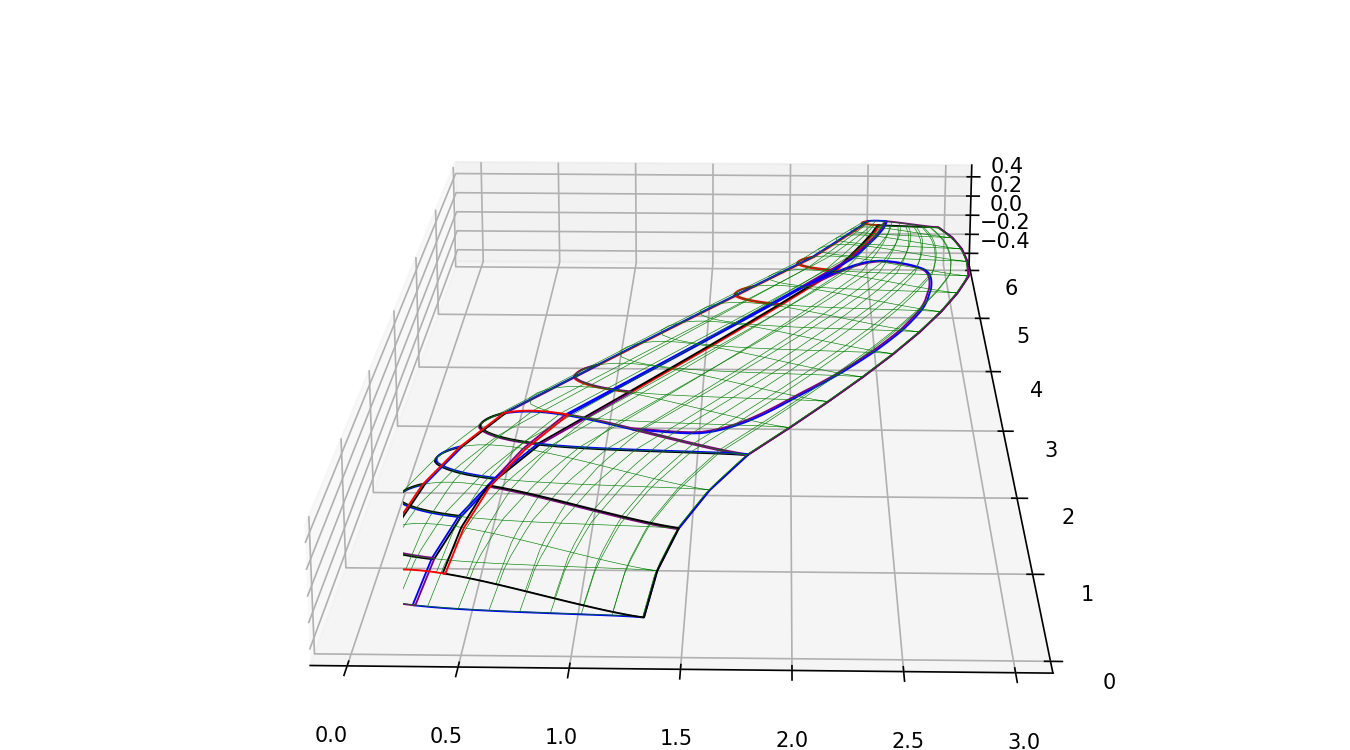

(0.0, 6.0)

In [19]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)